In [42]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import MaxPooling2D
from keras.models import Model, Sequential
#from tensorflow.python.keras.optimizer_v2.adam import Adam
#from keras.optimizers import adam_v2
from tensorflow.keras.optimizers import RMSprop
#from keras.optimizers import rmsprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
#obtain the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
#, SGD,RMSpro


# Clasifación de expresiones faciales con redes convolucionales

El objetivo de este notebook es la creación, manejo y entendimiento de las redes neronales convolucionacinoales para detección de expresiones faciales, para ello utilizamo sun dataset de 28821 imagenes de entrenamiento y 7066 imagenes de validación de dsitintas expresiones faciales como son la alegría, la tristeza, la sorpresa, el miedo, entre otras. Aplicaremos técnicas de Data Augmentation, early stopping, ReduceLROnPlateau, así como utilizar una red preentrenada en la comparación de los modelos. Por último haremos uso de la librería SHAP para aportar explicabilidad a los resultados.

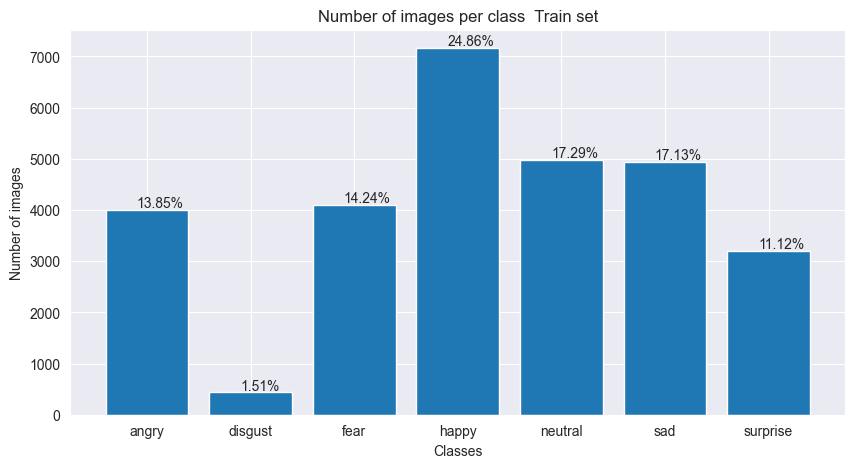

In [44]:
#bar plot of classes x axis and lista y axis
classes=os.listdir('./images/train/')
n_images_class=[]
for class_ in classes:
    path=os.path.join('./images/train/',class_)
    n_images_class.append(len(os.listdir(path)))
plt.figure(figsize=(10,5))
plt.bar(classes,n_images_class)
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Number of images per class  Train set')
#add the % to the top of the bar

for i in range(len(n_images_class)):
    plt.text(x=i-0.1 , y = n_images_class[i]+50, s=str(round(n_images_class[i]/sum(n_images_class)*100,2))+'%', size=10)    

plt.show()

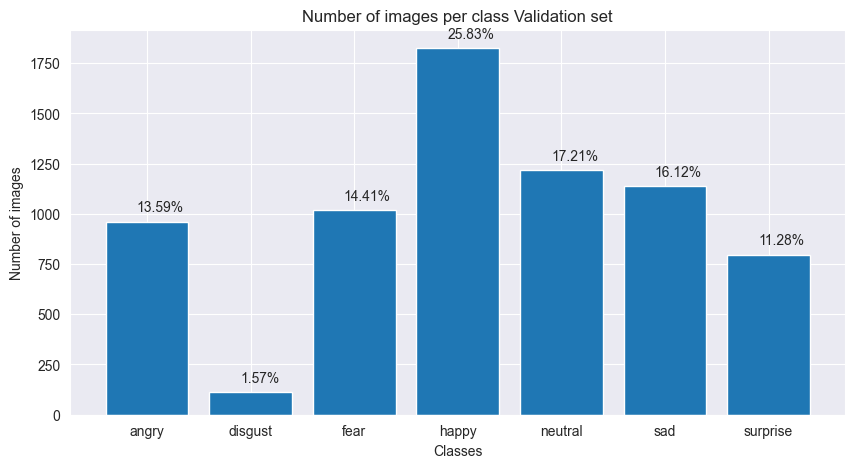

In [45]:
classes=os.listdir('./images/validation/')
n_images_class=[]
for class_ in classes:
    path=os.path.join('./images/validation/',class_)
    n_images_class.append(len(os.listdir(path)))

plt.figure(figsize=(10,5))
plt.bar(classes,n_images_class)
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Number of images per class Validation set')
#add the % to the top of the bar

for i in range(len(n_images_class)):
    plt.text(x=i-0.1 , y = n_images_class[i]+50, s=str(round(n_images_class[i]/sum(n_images_class)*100,2))+'%', size=10)    

plt.show()

Observamos que hay un claro `desbalance de clases`. Esto se pordría solucionar a través de una DataAugmentation diferente por cada clase o bien penalizando la función de perdida de la red a través de los `class_weigths`. Por otro lado debido a las pocas imagenes que tenemos de la clase `disgust` así como su similiaridad con tristeza, decidimos no tener el en cuenta este conjunto de imagenes. De esta manera el numero de clases que entrenaremos y evaluaremos es de 6.

In [46]:
folder_path = "./images/"
train_path = folder_path + "train"
classes_train = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d)) and d != "disgust"]

val_path = folder_path + "validation"
classes_val = [d for d in os.listdir(val_path) if os.path.isdir(os.path.join(val_path, d)) and d != "disgust"]

A continuación visualizamos las imagenes de la clase `happy` son imagenes pequeñas de 48 x 48, es por ello que se diferencian los pixeles al dibujar las clases. Por otro lado se observa que las imagenes solo tienen un canal, el gris. Posteriormente tendremos que modificar ciertas caracteristicas de la red convolucionales para hacer que capte esta imagenes procedentes de un solo canal gris.

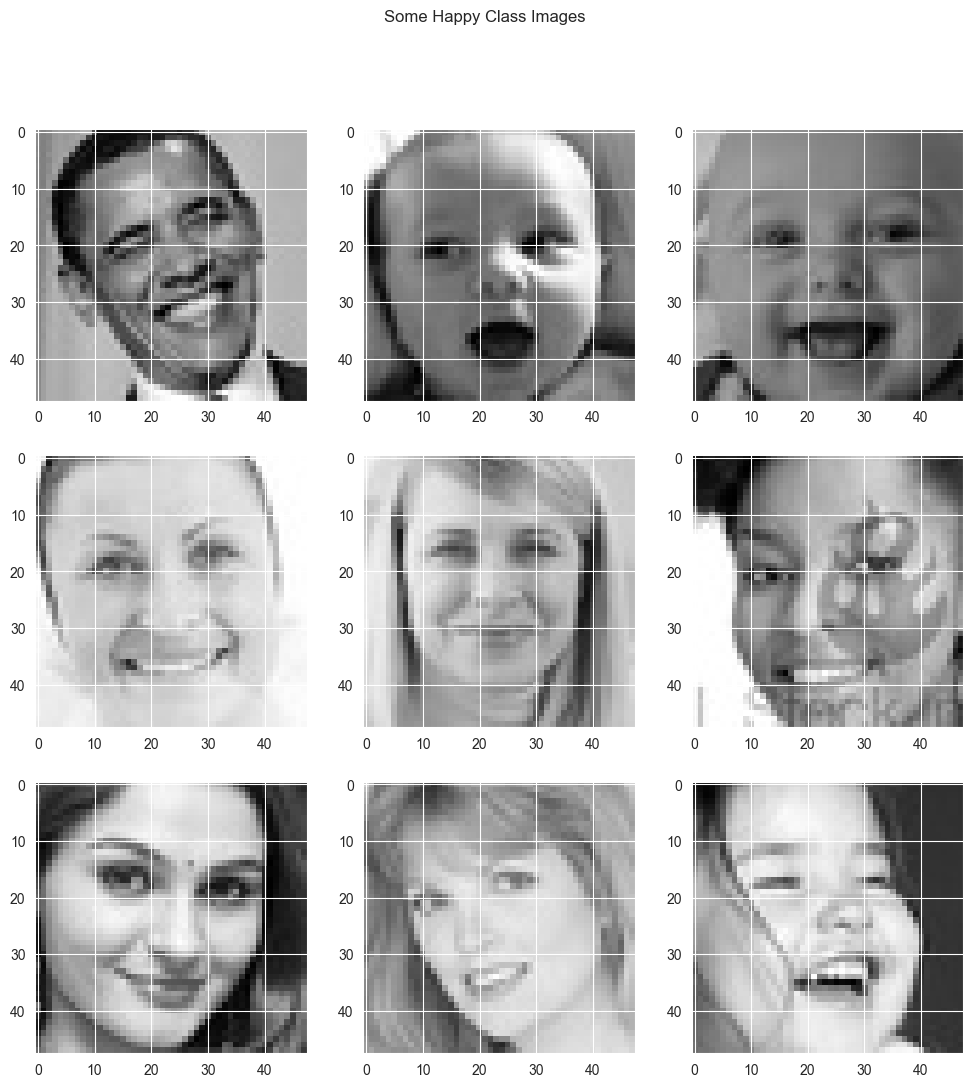

In [47]:
expression = 'happy'
picture_size = 48
plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.suptitle("Some Happy Class Images")
plt.show()

## CNN sin Data Augmentation
Este código crea dos $ImageDataGenerator$: `datagen_train` y `datagen_val`, para aplicar $Data  Augmentation$ en las imágenes de entrenamiento y validación, pero dados los argumentos no le hemos indicado que relamente generé nueva imagenes para las clases, lo haremos más adelante. Luego, se utiliza `flow_from_directory` de Keras para cargar las imágenes desde dos directorios distintos: `train y validation`. El conjunto de entrenamiento `(train_set)` generará `batch_size` imágenes nuevas en cada iteración, mientras que el conjunto de validación `(test_set)` no aplica Data Augmentation y simplemente carga las imágenes de validación sin modificar.

In [48]:
batch_size = 128

In [65]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
    folder_path + "train",
    target_size=(picture_size, picture_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    classes=classes_train
)

test_set = test_datagen.flow_from_directory(
    folder_path + "validation",
    target_size=(picture_size, picture_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=classes_val
)

Found 28385 images belonging to 6 classes.
Found 6955 images belonging to 6 classes.


En la siguiente celda generamos `la red convolucional from scratch` para ello importamos la clase $Sequential$ de keras y vamos añadiendo las distintas capas convolucionales con sus `filtros`, `normalizaciones`, `funciones de activación`, `pooling` para la reducción de dimensionalidad de las características y `drop out` dado para limitar el porcentaje de neuronas activas con el proposoito de evitar un sobrentrenamiento. Entonces aplicamos `cuatro capas convolucionales` las cuales se pueden ir variando y por ultimo dos capas densas dando el lugar al paso final de la clasificación, a través de la última función de activamiento usada para escenarios multiclase `softmax`.

Los pasos del modelo son los siguientes:

1. Se toma un lote `(batch)` de imágenes de entrenamiento de tamaño `batch_size`.
2. Se pasa el lote de imágenes por la red convolucional para obtener predicciones de las clases a las que pertenecen las imágenes.
4. Se calcula la `función de pérdida` (por ejemplo, la entropía cruzada) entre las predicciones y las verdaderas etiquetas de las imágenes del `lote`. La función de pérdida mide cuán mal se están haciendo las predicciones en comparación con las etiquetas verdaderas.
5. Se utiliza el algoritmo de retropropagación `(backpropagation)` para calcular las derivadas parciales de la función de pérdida con respecto a los pesos de la red. Estas derivadas parciales indican cómo se debe actualizar cada peso de la red para mejorar la precisión de las predicciones.
6. Se actualizan los pesos de la red utilizando un `optimizador` (por ejemplo, el descenso de gradiente estocástico) que utiliza las derivadas parciales calculadas en el paso anterior. La idea es ajustar los pesos de la red para reducir la pérdida en el siguiente lote de imágenes.
7. Se repiten los pasos `1-5` para cada lote de imágenes en el conjunto de entrenamiento.
Al final de una época, se mide la precisión de la red utilizando un conjunto de validación que no se ha utilizado para el entrenamiento. Esto se hace para comprobar que la red no se ha ajustado demasiado a los datos de entrenamiento y puede generalizar a nuevos datos.
8. Se repiten los pasos `1-7` para varias épocas hasta que se alcance una precisión aceptable en el conjunto de validación.
9. En cuanto a cuándo el modelo ha visto todos los datos de entrenamiento, esto ocurre después de que todos los lotes de imágenes de entrenamiento se hayan utilizado una vez durante una época. Si hay `n lotes` en el conjunto de entrenamiento y el tamaño del lote es `batch_size`, entonces el modelo habrá visto `n x batch_size` imágenes de entrenamiento en una `época`.
10. La función de pérdida se calcula en cada lote de imágenes de entrenamiento. Es decir, se calcula la pérdida para cada `lote` y se utilizan estas pérdidas para actualizar los pesos de la red.
11. Los pesos de la red se recalculan después de cada lote utilizando el `optimizador` que se ha elegido (por ejemplo, el descenso de gradiente estocástico). Por lo tanto, los pesos se actualizan varias veces durante una época, una vez para cada `lote`.

In [66]:
no_of_classes = 6

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.15))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.15))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.15))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))

model.add(Dense(no_of_classes, activation='softmax'))

In [67]:
opt = Adam(learning_rate = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 50

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [69]:
history_no_data_augmentation = model.fit(train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/50
221/221 [==============================] - 17s 74ms/step - loss: 1.6373 - accuracy: 0.3543 - val_loss: 1.9679 - val_accuracy: 0.3281 - lr: 0.0010
Epoch 2/50
221/221 [==============================] - 16s 74ms/step - loss: 1.2902 - accuracy: 0.4944 - val_loss: 1.5670 - val_accuracy: 0.4381 - lr: 0.0010
Epoch 3/50
221/221 [==============================] - 16s 74ms/step - loss: 1.1482 - accuracy: 0.5542 - val_loss: 1.5145 - val_accuracy: 0.4080 - lr: 0.0010
Epoch 4/50
221/221 [==============================] - 16s 74ms/step - loss: 1.0574 - accuracy: 0.5931 - val_loss: 1.2005 - val_accuracy: 0.5378 - lr: 0.0010
Epoch 5/50
221/221 [==============================] - 16s 74ms/step - loss: 0.9891 - accuracy: 0.6193 - val_loss: 1.5088 - val_accuracy: 0.4515 - lr: 0.0010
Epoch 6/50
221/221 [==============================] - 16s 74ms/step - loss: 0.9177 - accuracy: 0.6513 - val_loss: 1.2260 - val_accuracy: 0.5394 - lr: 0.0010
Epoch 7/50
221/221 [==============================] - 16s 

Queda visto que este último modelo debido a que no mejora en 5 epocas consecutivas, salta el `early stopping` siendo la última la época 16. Por otro lado en la siguiente celda mostramos la evolución de la `función de perdidas` y del `accuracy` a lo largo de las distintas `epocas`.

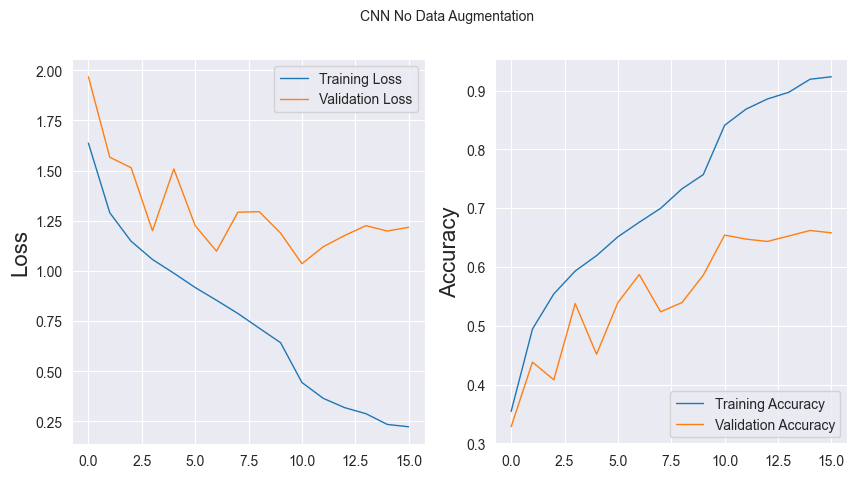

In [70]:
import seaborn as sns 
sns.set_style("darkgrid")

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history_no_data_augmentation.history['loss'], label='Training Loss',color = 'tab:blue', linewidth = 1)
plt.plot(history_no_data_augmentation.history['val_loss'], label='Validation Loss',color = 'tab:orange', linewidth = 1)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history_no_data_augmentation.history['accuracy'], label='Training Accuracy',color = 'tab:blue', linewidth = 1)
plt.plot(history_no_data_augmentation.history['val_accuracy'], label='Validation Accuracy',color = 'tab:orange', linewidth = 1)
plt.legend(loc='lower right')
plt.suptitle('CNN No Data Augmentation', fontsize=10)
plt.show()

Se observa que el modelo de esta manera sobrentrena, pues la puntuaciones de entrenamiento y de validación, están bastante separadas. Se observa como en las últimas epocas el modelo se va estancado en la mejora del `accuracy de validación`. Obteniendo un máximo de `0.65`

## CNN con Data Augmentation

Ahora pasamos a entrenar un modelo de `CNN` con `Data Augmentation` dado por los parametros de $ImageDataGenerator$, solo realizamos el aumento en los datos de entrenamiento, y el resto de pasos de mantienen analogos al anterior entrenamiento.

In [77]:
# Data augmentation con varios argumentos
datagen_train = ImageDataGenerator(
    horizontal_flip=True, # Invierte horizontalmente las imágenes
    rotation_range=10, # Gira aleatoriamente las imágenes hasta 10 grados
    zoom_range=0.1, # Aplica zoom aleatorio a las imágenes
    width_shift_range=0.1, # Desplaza horizontalmente las imágenes
    height_shift_range=0.1, # Desplaza verticalmente las imágenes
    shear_range=0.1, # Aplica cizalla a las imágenes
    fill_mode='nearest', # Rellena las imágenes después de aplicar transformaciones
    rescale=1./255, # Normaliza los valores de los píxeles
    validation_split=0.2 # Proporción de imágenes para validación
)

datagen_val = ImageDataGenerator(
    rescale=1./255, # Normaliza los valores de los píxeles
    validation_split=0.2 # Proporción de imágenes para validación
)

# Carga las imágenes de entrenamiento
train_set = datagen_train.flow_from_directory(
    folder_path + "train", # Directorio de imágenes de entrenamiento
    target_size=(picture_size, picture_size), # Tamaño de las imágenes
    color_mode="rgb", # Modo de color RGB
    batch_size=batch_size, # Tamaño del batch
    class_mode='categorical', # Modo de clasificación categórica
    shuffle=True, # Baraja aleatoriamente las imágenes
    classes=classes_train,
)


# Carga las imágenes de validación
test_set = datagen_val.flow_from_directory(
    folder_path + "validation", # Directorio de imágenes de validación
    target_size=(picture_size, picture_size), # Tamaño de las imágenes
    color_mode="rgb", # Modo de color RGB
    batch_size=batch_size, # Tamaño del batch
    class_mode='categorical', # Modo de clasificación categórica
    shuffle=False, # No baraja las imágenes
    classes=classes_val,
)


Found 28385 images belonging to 6 classes.
Found 6955 images belonging to 6 classes.


In [78]:
no_of_classes = 6

model2 = Sequential()

#1st CNN layer
model2.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,3)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Dropout(0.15))

#2nd CNN layer
model2.add(Conv2D(128,(5,5),padding = 'same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Dropout (0.15))

#3rd CNN layer
model2.add(Conv2D(512,(3,3),padding = 'same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Dropout (0.15))

#4th CNN layer
model2.add(Conv2D(512,(3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.15))

model2.add(Flatten())

#Fully connected 1st layer
model2.add(Dense(256))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.15))


# Fully connected layer 2nd layer
model2.add(Dense(512))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.15))

model2.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(learning_rate = 0.0001)

In [79]:
model2.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 50

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [81]:
history_data_augmentation = model2.fit(train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/50
221/221 [==============================] - 25s 107ms/step - loss: 1.8709 - accuracy: 0.2448 - val_loss: 1.8475 - val_accuracy: 0.1904 - lr: 1.0000e-04
Epoch 2/50
221/221 [==============================] - 23s 103ms/step - loss: 1.7362 - accuracy: 0.2983 - val_loss: 1.7728 - val_accuracy: 0.2629 - lr: 1.0000e-04
Epoch 3/50
221/221 [==============================] - 23s 103ms/step - loss: 1.6453 - accuracy: 0.3414 - val_loss: 1.5103 - val_accuracy: 0.3900 - lr: 1.0000e-04
Epoch 4/50
221/221 [==============================] - 23s 103ms/step - loss: 1.5848 - accuracy: 0.3675 - val_loss: 1.4508 - val_accuracy: 0.4203 - lr: 1.0000e-04
Epoch 5/50
221/221 [==============================] - 23s 103ms/step - loss: 1.5277 - accuracy: 0.3922 - val_loss: 1.4490 - val_accuracy: 0.4446 - lr: 1.0000e-04
Epoch 6/50
221/221 [==============================] - 23s 103ms/step - loss: 1.4769 - accuracy: 0.4177 - val_loss: 1.3897 - val_accuracy: 0.4523 - lr: 1.0000e-04
Epoch 7/50
221/221 [========

El modelo paró debido al `early stopping` en la `época 43`, tardando más que el anterior en ser parado, por lo que fue mejorando gradualemnte más anterior. Por otro lado, el tiempo de ejecución aumentó debido al incremento en el numero de imagenes dado por el $Data Augmentation$ definido. La mejor puntuación obtenida en la validación de este modelo es de `0.63`

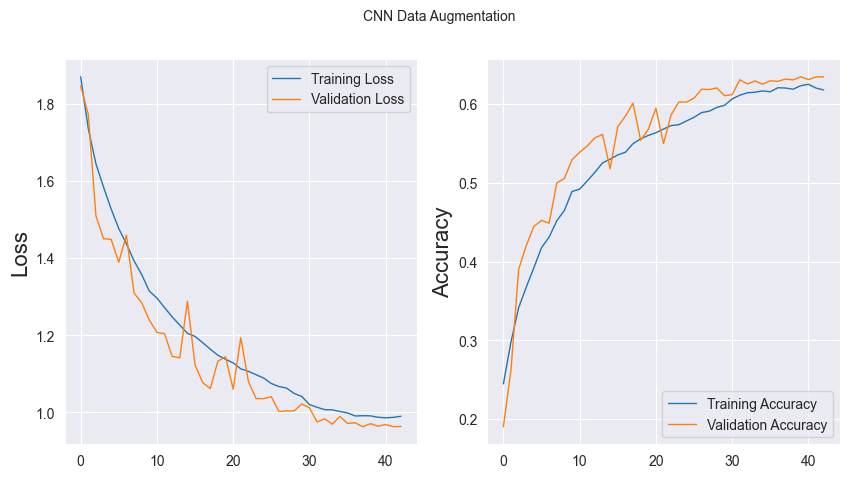

In [82]:
import seaborn as sns 
sns.set_style("darkgrid")

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history_data_augmentation.history['loss'], label='Training Loss',color = 'tab:blue', linewidth = 1)
plt.plot(history_data_augmentation.history['val_loss'], label='Validation Loss',color = 'tab:orange', linewidth = 1)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history_data_augmentation.history['accuracy'], label='Training Accuracy',color = 'tab:blue', linewidth = 1)
plt.plot(history_data_augmentation.history['val_accuracy'], label='Validation Accuracy',color = 'tab:orange', linewidth = 1)
plt.legend(loc='lower right')
plt.suptitle('CNN Data Augmentation', fontsize=10)
plt.show()

La evolución del `accuaracy` y de la `función de perdida` respecto al entrenamiento y la validación está mucho más equilibribrada que en el caso anterior. Por lo que hemos obtenido un modelo más robusto.
Dado que el modelo ha mejorado vamos a observar la matriz de confusión de las distintas clases en los datos de validación.

55/55 [==============================] - 2s 41ms/step


<Figure size 640x480 with 0 Axes>

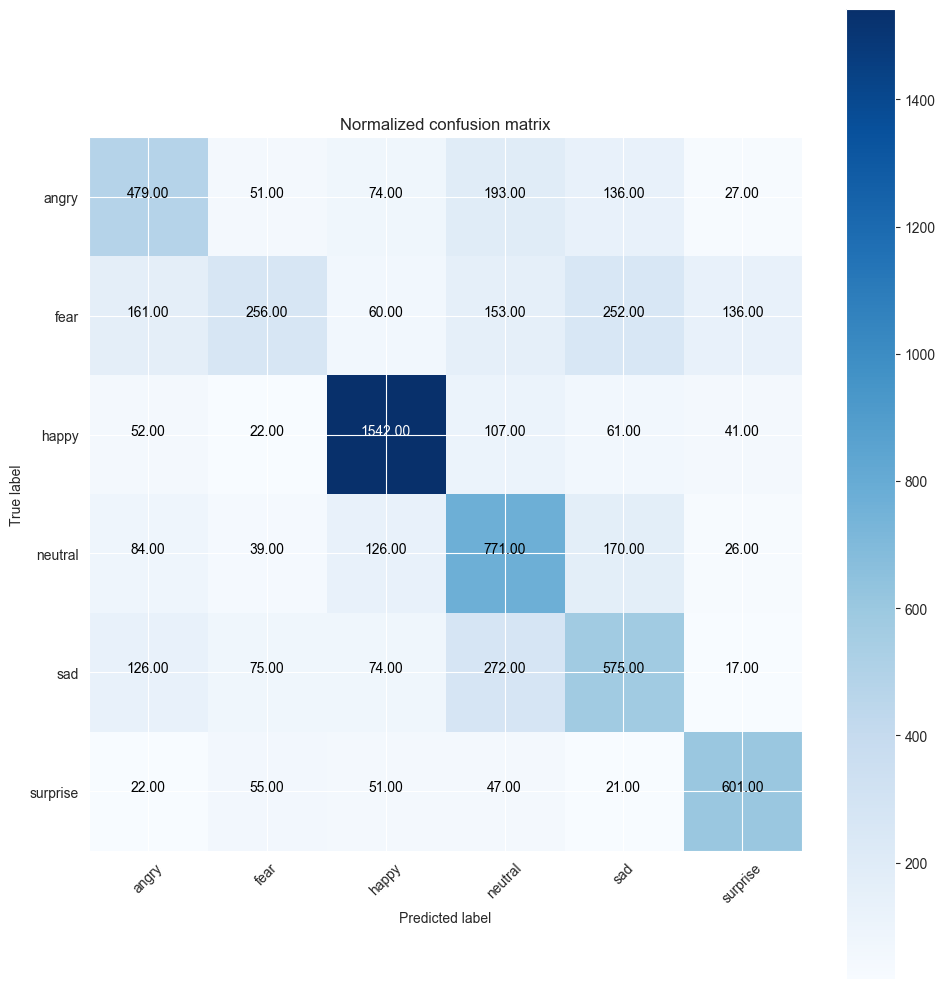

In [63]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model2.predict(test_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_set.classes
class_names = test_set.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float')
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix with non normalized values
cnf_matrix = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

Puesto que las clases estan desbalanceadas puede ser interesante medir el `balanced accuracy`

In [64]:
print("Balanced Accuracy Validación",balanced_accuracy_score(y_test, y_pred))

print("Accuracy Validación", accuracy_score(y_test, y_pred))


Balanced Accuracy Validación 0.5813859931883951
Accuracy Validación 0.607332854061826


## CNN preentrenada

In [ ]:
# !pip install keras_applications
# !pip install keras_vggface

In [84]:
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

A través de la librería VGG16 hacemos uso de los pesos del modelo `imagenet`

In [85]:
model_vg=VGG16(weights='imagenet',include_top=False, input_shape=(48, 48, 3))
model_vg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

Lo que vamos a hacer es añadir una nuevas capas finales a las ya entrenadas, en este caso no descongelamos nada para volver a entrenar sino que añadimos nuevas capas densas.

In [86]:
#lets create a new model
model_new=Sequential()

#add the vgg16 model
model_new.add(model_vg)

#add new layers
model_new.add(Flatten())

#Fully connected 1st layer
model_new.add(Dense(256))
model_new.add(BatchNormalization())
model_new.add(Activation('relu'))
model_new.add(Dropout(0.25))


# Fully connected layer 2nd layer
model_new.add(Dense(512))
model_new.add(BatchNormalization())
model_new.add(Activation('relu'))
model_new.add(Dropout(0.25))

model_new.add(Dense(no_of_classes, activation='softmax'))


#freeze the layers of vgg16 model
for layer in model_vg.layers:
    layer.trainable=False

#compile the model
model_new.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

#train the model
history = model_new.fit(train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

c:\Users\Diego\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Diego\AppData\Local\Temp\ipykernel_13252\3495175522.py:36: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_new.fit_generator(generator=train_set,


Epoch 1/50
221/221 [==============================] - 99s 425ms/step - loss: 1.7479 - accuracy: 0.3146 - val_loss: 1.5536 - val_accuracy: 0.3853 - lr: 0.0010
Epoch 2/50
221/221 [==============================] - 86s 389ms/step - loss: 1.6117 - accuracy: 0.3531 - val_loss: 1.5461 - val_accuracy: 0.3811 - lr: 0.0010
Epoch 3/50
221/221 [==============================] - 61s 276ms/step - loss: 1.5601 - accuracy: 0.3746 - val_loss: 1.5086 - val_accuracy: 0.4104 - lr: 0.0010
Epoch 4/50
221/221 [==============================] - 61s 276ms/step - loss: 1.5361 - accuracy: 0.3842 - val_loss: 1.5394 - val_accuracy: 0.3873 - lr: 0.0010
Epoch 5/50
221/221 [==============================] - 59s 265ms/step - loss: 1.5145 - accuracy: 0.3924 - val_loss: 1.4663 - val_accuracy: 0.4297 - lr: 0.0010
Epoch 6/50
221/221 [==============================] - 60s 272ms/step - loss: 1.5005 - accuracy: 0.4054 - val_loss: 1.4638 - val_accuracy: 0.4229 - lr: 0.0010
Epoch 7/50
221/221 [==============================] 

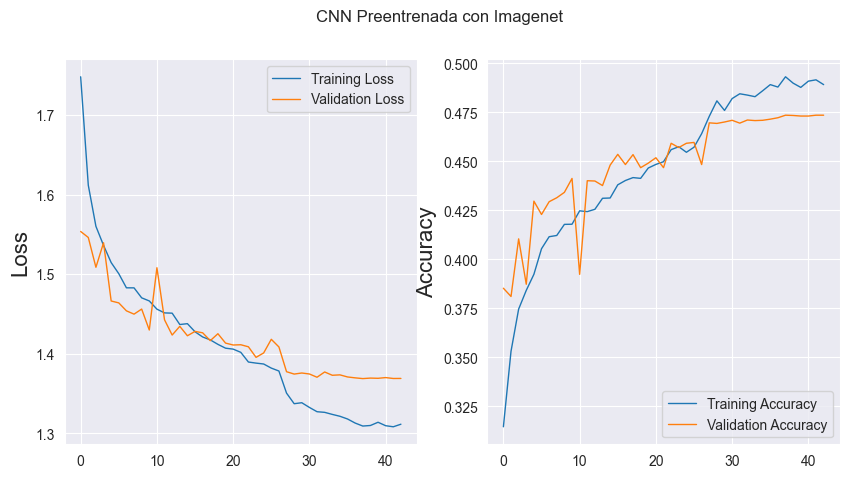

In [87]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss',color = 'tab:blue', linewidth = 1)
plt.plot(history.history['val_loss'], label='Validation Loss',color = 'tab:orange', linewidth = 1)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy',color = 'tab:blue', linewidth = 1)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',color = 'tab:orange', linewidth = 1)
plt.legend(loc='lower right')
plt.suptitle('CNN Preentrenada con Imagenet')
plt.show()